In [5]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
from pyspark.sql import SparkSession
import numpy as np
import seaborn as sns
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

import pyspark
from pyspark.ml import feature, regression,classification, Pipeline
from pyspark.sql import functions as fn, Row
from pyspark import sql

import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [6]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [7]:
df = pd.read_csv('diabetic_data.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

In [9]:
for i in range(24,47): #No-0,Down-1,Up-2,Steady-3
    df[df.columns[i]] = df[df.columns[i]].map({'No': -2, 'Down': -1, "Up":1, 'Steady':0})

In [10]:
df['readmitted'] = df['readmitted'].map({'NO': 0, '<30': 1, ">30":2})
df['readmittedbinary'] = df['readmitted'].map({0: 0, 1: 1, 2:1})

In [11]:
df['change'] = df['change'].map({'No': -1, 'Ch': 1})#No-0,Ch-1

In [12]:
df['max_glu_serum'] = df['max_glu_serum'].map({'None': 0, '>200': 2,'>300':3,'Norm':1})

In [13]:
df['A1Cresult'] = df['A1Cresult'].map({'None': 0, '>7': 7,'>8':8,'Norm':5})

In [14]:
df['diabetesMed'] = df['diabetesMed'].map({'No': -1, 'Yes': 1})

In [15]:
df['age'] = df['age'].map({'[0-10)':5,'[10-20)':15, '[20-30)':25,'[30-40)':35,'[40-50)':45,'[50-60)':55,'[60-70)':65,'[70-80)':75,'[80-90)':85,'[90-100)':95})

In [16]:
df.drop(['encounter_id','patient_nbr','weight','admission_type_id','discharge_disposition_id','admission_source_id','medical_specialty','payer_code'],axis=1,inplace=True)


In [17]:
df=df.loc[df['gender'].isin(['Male','Female'])]#df.loc[df['B'].isin(['one','three'])]

In [18]:
df.replace('?', np.nan, inplace = True)

In [19]:
df= df.dropna()##Clean pandas df without dummy variables 

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98052 entries, 1 to 101765
Data columns (total 43 columns):
race                        98052 non-null object
gender                      98052 non-null object
age                         98052 non-null int64
time_in_hospital            98052 non-null int64
num_lab_procedures          98052 non-null int64
num_procedures              98052 non-null int64
num_medications             98052 non-null int64
number_outpatient           98052 non-null int64
number_emergency            98052 non-null int64
number_inpatient            98052 non-null int64
diag_1                      98052 non-null object
diag_2                      98052 non-null object
diag_3                      98052 non-null object
number_diagnoses            98052 non-null int64
max_glu_serum               98052 non-null int64
A1Cresult                   98052 non-null int64
metformin                   98052 non-null int64
repaglinide                 98052 non-null int64
nat

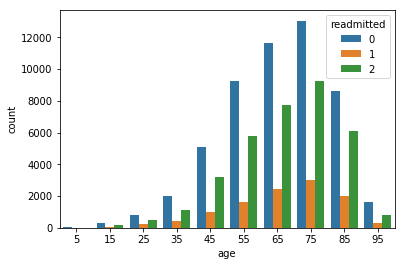

In [21]:
a = sns.countplot(x = df['age'], hue= df['readmitted'])

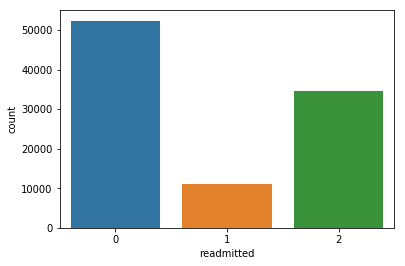

In [22]:
d = sns.countplot(x = df['readmitted'])

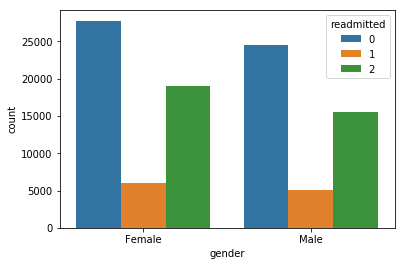

In [23]:
b = sns.countplot(x = df['gender'], hue= df['readmitted'])

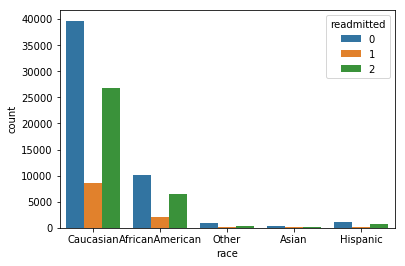

In [24]:
c = sns.countplot(x = df['race'], hue= df['readmitted'])

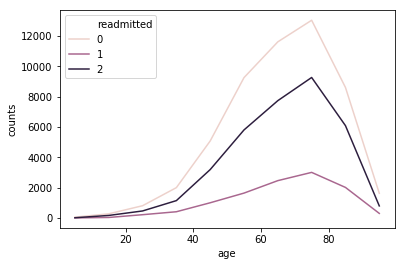

In [25]:
count_of_y = df["age"].groupby(df["readmitted"]).value_counts().rename("counts").reset_index()
count_of_y
fig = sns.lineplot(x="age", y="counts", hue="readmitted", data=count_of_y)

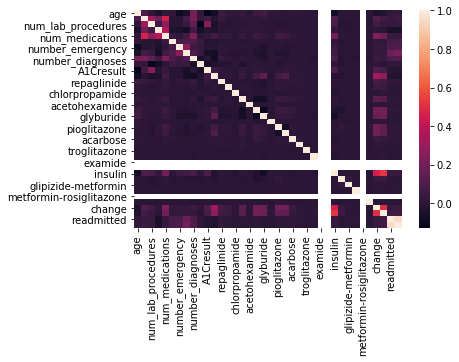

In [26]:
sns.heatmap(df.corr())

In [35]:
plt.figure(figsize=(25, 8))
a = df.corr()
b = a['readmitted']
c= b.to_frame()
type(c)
c.sort_values(by = ['readmitted'], ascending = False , inplace = True)
pos = c.head(8)
c.sort_values(by = ['readmitted'], ascending = True , inplace = True)
neg = c.head(8)
neg
pos.index.name = 'feature'
pos.reset_index(inplace=True)
pos
neg.index.name = 'feature'
neg.reset_index(inplace=True)
neg

,feature,readmitted
0,num_procedures,-0.045244
1,metformin,-0.022620
2,A1Cresult,-0.007674
3,tolazamide,-0.003763
4,tolbutamide,-0.003706
5,glyburide,-0.002927
6,metformin-pioglitazone,-0.002831
7,chlorpropamide,0.002161


<Figure size 1800x576 with 0 Axes>

In [36]:
plt.figure(figsize=(25, 8))

<Figure size 1800x576 with 0 Axes>

<Figure size 1800x576 with 0 Axes>

In [37]:
pos=pos.drop(pos.index[0])
pos

,feature,readmitted
1,readmittedbinary,0.948634
2,number_inpatient,0.175999
3,number_diagnoses,0.096760
4,number_emergency,0.089030
5,number_outpatient,0.079847
6,diabetesMed,0.057924
7,change,0.041999


[Text(0,0,'readmittedbinary'),
 Text(0,0,'number_inpatient'),
 Text(0,0,'number_diagnoses'),
 Text(0,0,'number_emergency'),
 Text(0,0,'number_outpatient'),
 Text(0,0,'diabetesMed'),
 Text(0,0,'change')]

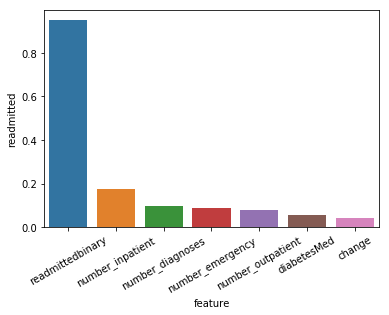

In [38]:
posplot = sns.barplot(x='feature', y="readmitted", data=pos)
posplot.set_xticklabels(posplot.get_xticklabels(),rotation=30)

In [39]:
type(posplot)

matplotlib.axes._subplots.AxesSubplot

[Text(0,0,'num_procedures'),
 Text(0,0,'metformin'),
 Text(0,0,'A1Cresult'),
 Text(0,0,'tolazamide'),
 Text(0,0,'tolbutamide'),
 Text(0,0,'glyburide'),
 Text(0,0,'metformin-pioglitazone'),
 Text(0,0,'chlorpropamide')]

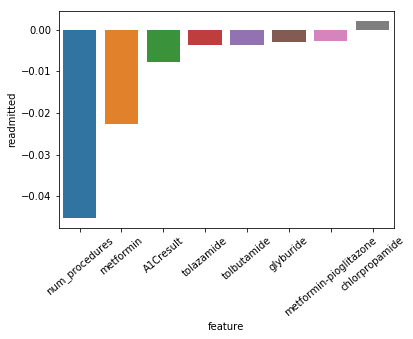

In [40]:
negplot = sns.barplot(x='feature', y="readmitted", data=neg)
negplot
negplot.set_xticklabels(negplot.get_xticklabels(),rotation=40)